# Using SPAM algorithm to generate LDCs

SPAM, which stands for Synthetic-Photometry/Atmosphere-Model, is an algorith to generate limb darkening coefficients from synthetic exoplanet transit photometry using model stellar atmospheres. The model originally presented in [Howarth (2011)](https://academic.oup.com/mnras/article/418/2/1165/1071889) and modified in [Espinoza & Jordan (2015)](https://academic.oup.com/mnras/article/450/2/1879/985166); we, here, used the modified version of the same code from [Espinoza & Jordan (2015)](https://academic.oup.com/mnras/article/450/2/1879/985166), named as MC-SPAM (stands for Monte-Carlo SPAM algorithm). The main difference between both versions in that the later deals with the uncertainties in the transit parameters.

A prime motivation behind the algorithm is to provide a proper set of limb darkening coefficients which can be used in comparison with the ones derived from the transit photometry. Most of the tables (see, [Claret 2017](https://www.aanda.org/articles/aa/full_html/2017/04/aa29705-16/aa29705-16.html) for example) that provide computed set of the limb-darkening coefficients fit intensity profile from model stellar atmospheres to the limb-darkening laws to compute the LDCs. Or there are many other methods as well, however, all of them primarily use intensity profile to find LDCs (see, [Howarth 2011](https://academic.oup.com/mnras/article/418/2/1165/1071889)). This method to determine the limb-darkening coefficients is inherently different from the one which fits the exoplanet transit lightcurves to obtain LDCs. It is thus inevitable to get different sets of LDCs from both of these methods, hence, it is not advisable to compare both sets of LDCs directly with each other --- they would show a discrepancy between them. [Howarth (2011)](https://academic.oup.com/mnras/article/418/2/1165/1071889) proposed an elegant way forward with SPAM algorithm.

The basic idea is simple: the intensity profile of a given star can be used to compute a synthetic exoplanet transit lightcurve using the parameters of a given exoplanet. An another transit lightcurve model is now produced with limb-darkening coefficients as free parameters --- this model is then fitted to the sythetic transit lightcurve to yield the LDCs while fitting for the transit parameters as well.

One of the drawbacks of this algorithm is its ignorance towards the uncertainties in transit parameters. [Espinoza & Jordan (2015)](https://academic.oup.com/mnras/article/450/2/1879/985166) proposed a new [MC-SPAM](https://github.com/nespinoza/mc-spam) (Monte-Carlo SPAM) algorithm to overcome this shortcoming. Furthermore, in this version of SPAM, the transit parameters are fixed in the last step.

In this notebook, we demonstrate the MC-SPAM algorithm and its usage.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import batman
from scipy.optimize import curve_fit as cft
from scipy.optimize import minimize as mz
from scipy.optimize import leastsq as lsq
from tqdm import tqdm

We now use $\texttt{batman}$ package to define a transit model, which takes stellar and planetary transit parameters and gives flux at each phase.

In [2]:
def transit(time, t0, per, rp, a, b, ecc, w, u, law):
    para = batman.TransitParams()
    para.t0 = t0
    para.per = per
    para.rp = rp
    para.a = a
    cosi = b/a
    in1 = 180*np.arccos(cosi)/np.pi
    para.inc = in1
    para.ecc = ecc
    para.w = w
    para.u = u
    para.limb_dark = law
    m = batman.TransitModel(para, time)
    fl = m.light_curve(para)
    return fl

We now demonstrate the usage of this function with planetary parameters of WASP-62 system:
- $P = 4.41193789 \pm 0.000000315$
- $R_p/R_* = 0.11108 \pm 0.00015$
- $a/R_* = 9.719 \pm 0.032$
- $b = 0.228 \pm 0.015$
- $ecc = 0.0$
- $\omega = 90^\circ$
- $u_{non-linear} = [0.461242, 0.339466, -0.16376, 3.4e-05]$
- $u_{juliet} = [0.302 \pm 0.013, 0.134 \pm 0.027]$

We can compute limiting limb-darkening coefficients (see, [Espinoza & Jordan 2015](https://academic.oup.com/mnras/article/450/2/1879/985166) for details), for [Claret (2017)](https://www.aanda.org/articles/aa/full_html/2017/04/aa29705-16/aa29705-16.html) ATLAS coefficients.

- $u_{limiting} = [0.24189659047619047, 0.3079834603174603]$

Below, we plot our synthetic lightcurve using the function defined above (using non-linear LDCs),

Text(0, 0.5, 'Normalized flux')

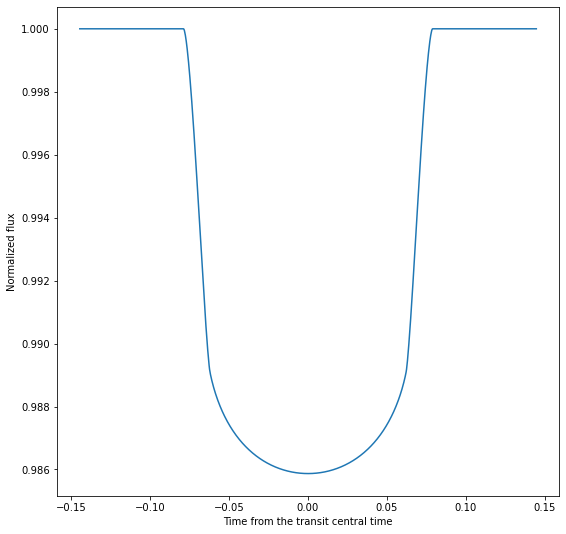

In [3]:
time = np.linspace(-4.41193789/(9.719*np.pi), 4.41193789/(9.719*np.pi), 1000)
flux = transit(time, 0., 4.41193789, 0.11108, 9.719, 0.228, 0., 90., [0.461242, 0.339466, -0.16376, 3.4e-05], "nonlinear")
flux_jl = transit(time, 0., 4.41193789, 0.11108, 9.719, 0.228, 0., 90., [0.302, 0.134], "quadratic")

plt.figure(figsize=(9,9))
plt.plot(time, flux)
plt.xlabel('Time from the transit central time')
plt.ylabel('Normalized flux')

We now have the synthetic lightcurve we wanted --- we can now use this template to fit model lightcurve to retrieve quadratic limb darkening coefficients. Below we use $\chi^2$-minimization technique to find the quadratic LDCs. As an initial guess, we use limiting LDCs from [Espinoza & Jordan 2015](https://academic.oup.com/mnras/article/450/2/1879/985166).

In [4]:
def min_log_likelihood(x):
    model = transit(time, 0., 4.41193789, 0.11108, 9.719, 0.228, 0., 90., x, "quadratic")
    chi2 = np.sum((flux-model)**2)
    return chi2

soln = mz(min_log_likelihood, x0=[0.2306076190476191, 0.3186269841269841], method='L-BFGS-B')
soln

      fun: 1.0952459083885296e-07
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.05713242e-06, 5.02977828e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 30
      nit: 8
     njev: 10
   status: 0
  success: True
        x: array([0.29428534, 0.21375244])

Let's plot the solution...

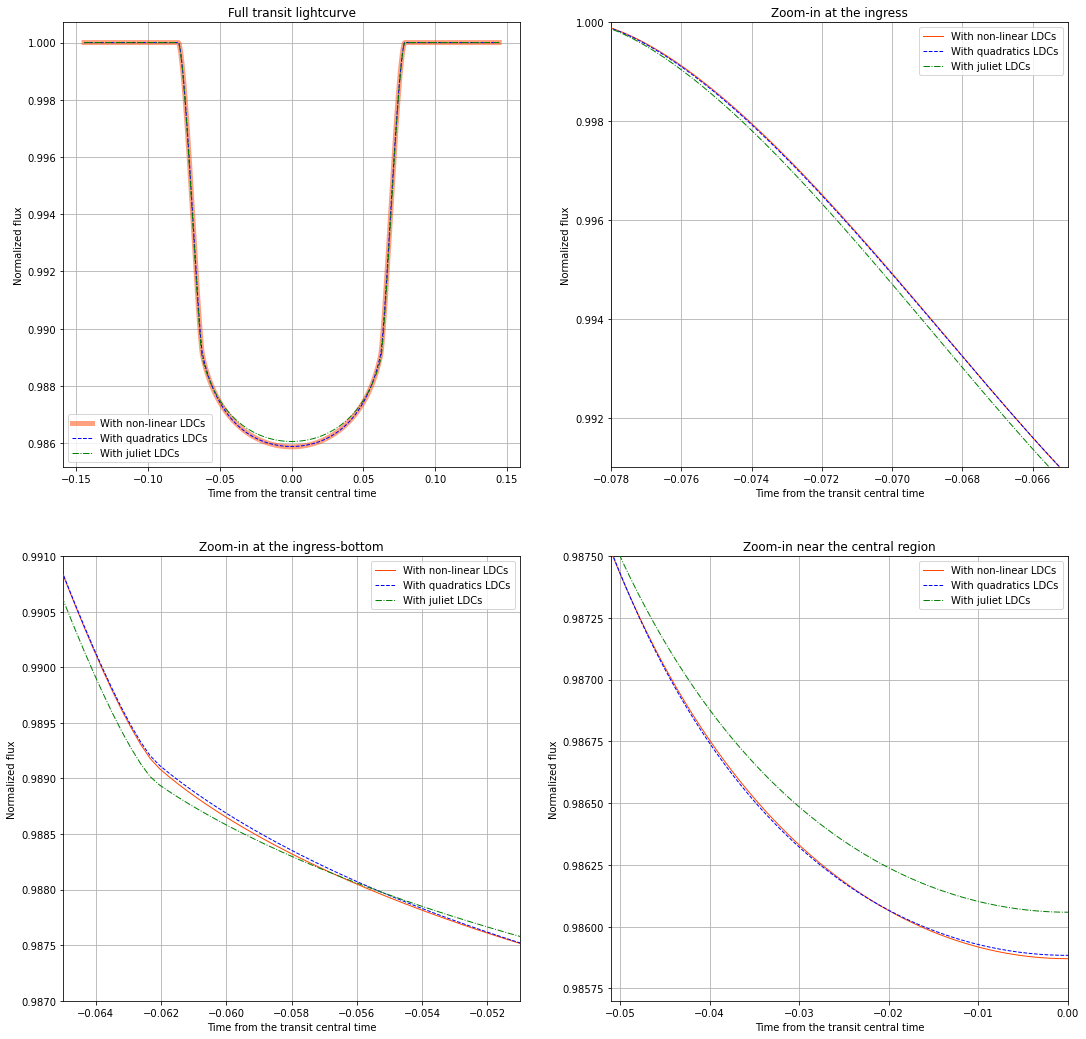

In [5]:
flux_qua = transit(time, 0., 4.41193789, 0.11108, 9.719, 0.228, 0., 90., soln.x, "quadratic")

fig, axs = plt.subplots(nrows=2, ncols=2,
                                    figsize=(18, 18))
axs[0,0].plot(time, flux, lw=5, color='orangered', alpha=0.5, zorder=5, label='With non-linear LDCs')
axs[0,0].plot(time, flux_qua, lw=1, ls='--', color='blue', zorder=10, label='With quadratics LDCs')
axs[0,0].plot(time, flux_jl, lw=1, ls='-.', color='green', zorder=10, label='With juliet LDCs')
axs[0,0].set_xlabel('Time from the transit central time')
axs[0,0].set_ylabel('Normalized flux')
axs[0,0].legend(loc='best')
axs[0,0].set_title('Full transit lightcurve')
axs[0,0].grid()

axs[0,1].plot(time, flux, lw=1, color='orangered', alpha=1.0, zorder=5, label='With non-linear LDCs')
axs[0,1].plot(time, flux_qua, lw=1, ls='--', color='blue', zorder=10, label='With quadratics LDCs')
axs[0,1].plot(time, flux_jl, lw=1, ls='-.', color='green', zorder=10, label='With juliet LDCs')
axs[0,1].set_xlabel('Time from the transit central time')
axs[0,1].set_ylabel('Normalized flux')
axs[0,1].legend(loc='best')
axs[0,1].set_xlim([-0.078,-0.065])
axs[0,1].set_ylim([0.991, 1.000])
axs[0,1].set_title('Zoom-in at the ingress')
axs[0,1].grid()

axs[1,0].plot(time, flux, lw=1, color='orangered', alpha=1.0, zorder=5, label='With non-linear LDCs')
axs[1,0].plot(time, flux_qua, lw=1, ls='--', color='blue', zorder=10, label='With quadratics LDCs')
axs[1,0].plot(time, flux_jl, lw=1, ls='-.', color='green', zorder=10, label='With juliet LDCs')
axs[1,0].set_xlabel('Time from the transit central time')
axs[1,0].set_ylabel('Normalized flux')
axs[1,0].legend(loc='best')
axs[1,0].set_xlim([-0.065, -0.051])
axs[1,0].set_ylim([0.9870, 0.9910])
axs[1,0].set_title('Zoom-in at the ingress-bottom')
axs[1,0].grid()

axs[1,1].plot(time, flux, lw=1, color='orangered', alpha=1.0, zorder=5, label='With non-linear LDCs')
axs[1,1].plot(time, flux_qua, lw=1, ls='--', color='blue', zorder=10, label='With quadratics LDCs')
axs[1,1].plot(time, flux_jl, lw=1, ls='-.', color='green', zorder=10, label='With juliet LDCs')
axs[1,1].set_xlabel('Time from the transit central time')
axs[1,1].set_ylabel('Normalized flux')
axs[1,1].legend(loc='best')
axs[1,1].set_xlim([-0.051, 0.00])
axs[1,1].set_ylim([0.9857, 0.9875])
axs[1,1].set_title('Zoom-in near the central region')
axs[1,1].grid()

It is clear that our fitting worked. The modelled transit lightcurve matches very well with the synthetic transit lightcurve. However, we note here that this matching is not perfect, especially at the central region and the ingress/egress region, as can be seen in the bottom panels of the figure above. Note that, both of the models are still far from the fitted lightccurve from `juliet`.

Before moving further, we, below, present the basic SPAM algorithm in a function `spam`. It will take values of planetary parameters and non-linear limb darkening coefficients and returns the SPAM LDCs. This function is basically the summary of the codes we presented till now.

In [6]:
def spam(time, per, rp, a, b, u, ecc=0., w=90., t0=0.):
    synthetic_flux = transit(time, t0, per, rp, a, b, ecc, w, u, "nonlinear")
    def min_log_likelihood(x):
        model = transit(time, t0, per, rp, a, b, ecc, w, x, "quadratic")
        chi2 = np.sum((synthetic_flux-model)**2)
        return chi2
    u1_guess, u2_guess = (12./35.)*u[0] + u[1] + (164./105.)*u[2] + 2.*u[3], (10./21.)*u[0] - (34./63.)*u[2] - u[3]
    soln = mz(min_log_likelihood, x0=[u1_guess, u2_guess], method='L-BFGS-B')
    return soln.x

In [7]:
u_spam = spam(time, 4.41193789, 0.11108, 9.719, 0.228, [0.461242, 0.339466, -0.16376, 3.4e-05])
print(u_spam)

[0.29399358 0.21447121]


## MC-SPAM

As already discussed the original SPAM algorithm doesn't take care of the unccertainties involved in the planetary and stellar parameters. The Monte-Carlo SPAM ([MC-SPAM](https://github.com/nespinoza/mc-spam)) by [Espinoza & Jordan (2015)](https://academic.oup.com/mnras/article/450/2/1879/985166) solves this problem. Below we present the code for this new algorithm.

In [8]:
def mc_spam(time, per, per_err, rp, rp_err, a, a_err, b, b_err, u, ecc=0., w=90., t0=0.):
    period = np.random.normal(per, per_err, 1000)
    rp1 = np.random.normal(rp, rp_err, 1000)
    ar1 = np.random.normal(a, a_err, 1000)
    b1 = np.random.normal(b, b_err, 1000)
    u1_mcs, u2_mcs = np.zeros(1000), np.zeros(1000)
    for i in tqdm(range(len(period))):
        u1_mcs[i], u2_mcs[i] = spam(time, period[i], rp1[i], ar1[i], b1[i], u)
    return u1_mcs, u2_mcs

In [9]:
u1_mcspan, u2_mcspan = mc_spam(time, 4.41193789, 0.000000315, 0.11108, 0.00015, 9.719, 0.032, 0.228, 0.015, [0.461242, 0.339466, -0.16376, 3.4e-05])

print('MC-SPAM value of u1: {:.4f} +/- {:.4f}'.format(np.median(u1_mcspan), np.std(u1_mcspan)))
print('MC-SPAM value of u2: {:.4f} +/- {:.4f}'.format(np.median(u2_mcspan), np.std(u2_mcspan)))

100%|██████████| 1000/1000 [01:46<00:00,  9.35it/s]

MC-SPAM value of u1: 0.2940 +/- 0.0008
MC-SPAM value of u2: 0.2145 +/- 0.0007
